In [9]:
import os
import librosa
from pydub import AudioSegment
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

import scipy.io.wavfile

import pandas as pd

## convert m4a to wav

In [11]:
print(os.getcwd())
db = './data_db/'

cnt = 0
for path, dirs, files in os.walk(db):
    for file in files:
        if file.endswith('m4a'):
            name, _ = file.split('.')
            file_path = os.path.join(path, file)
            wav_file = os.path.join(path, name+'.wav')
            try:
                track = AudioSegment.from_file(file_path, format="m4a")
                conv_wav = track.export(wav_file, format="wav")
                print(f'CONVERTING: {wav_file}')
                cnt += 1
                os.remove(file_path)
            except:
                print("Error")
print(cnt)

c:\Users\mjw27\Desktop\Speech-Emotion-Analyzer-master\gender_model
0


## 음성 feature extraction

음성이 3초 이상인 data는 0.5초부터 2.5초씩 load(22050 * 2.5 = 55125)  
3초 이하인 data는 처음부터 load  
0.2초씩 slide window(4410)  

22050 300032
[ 2.6458016e-09 -2.3710547e-07  5.2862521e-07 ... -8.2520518e-07
  1.5283086e-06 -4.8197048e-06]
44100 600064


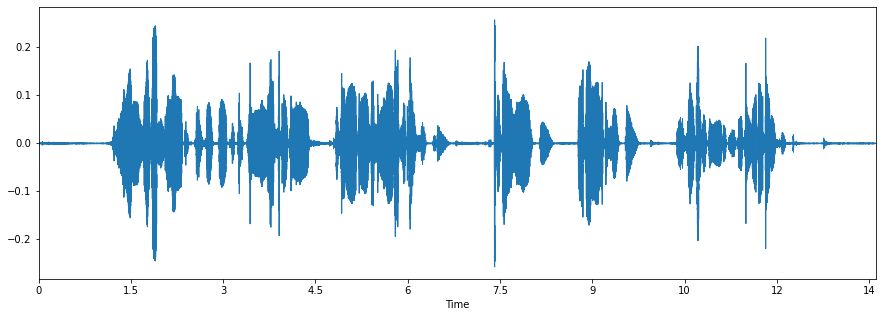

In [3]:
# 정규화, resampling
x, sr = librosa.load('./data_db/woman/kor/이지윤_angry_12.wav')
print(sr, len(x))
print(x)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr=sr)
# 정규화 x
sr,x = scipy.io.wavfile.read('./data_db/woman/kor/이지윤_angry_12.wav')
print(sr, len(x))


In [10]:
db = './data_db/'
language = ['eng', 'kor']
gender = ['man', 'woman']

mfcc = 20
sr = 22050
win_size = int(sr *  2.5)
win_slide = int(sr * 0.2)
margin = win_size // win_slide

min_audio = int(sr * 3)
offset = int(sr * 0.5)

df = pd.DataFrame(columns=['gender', 'language', 'feature'])
cnt = 0

for path, dirs, files in os.walk(db):
    for file in files:
        lang = path.split('\\')[-1]
        gen = path.split('\\')[0].split('/')[-1]

        file_path = os.path.join(path, file)
        data, sr = librosa.load(file_path, sr=sr)

        if len(data) >= min_audio:
            data = data[offset:]
        step = round(len(data) / win_slide - margin)

        if step <= 0:
            pass
        else:
            for i in range(step):
                s_idx = i * win_slide
                e_idx = i * win_slide + win_size
                if e_idx >= len(data):
                    break
                step_data = data[s_idx:e_idx]
                mfccs = np.mean(librosa.feature.mfcc(y=step_data, sr=sr, n_mfcc=mfcc), axis=0) #(108,)
                df.loc[cnt, 'gender'] = gender.index(gen)
                df.loc[cnt, 'language'] = language.index(lang)
                df.loc[cnt, 'feature'] = (", ".join(repr(m) for m in mfccs))
                cnt += 1

print(df)


      gender language                                            feature
0          0        0  -43.007637, -43.007637, -43.007637, -43.007637...
1          0        0  -43.005123, -41.460415, -38.621128, -37.740406...
2          0        0  -39.88351, -39.199074, -38.777107, -41.36376, ...
3          0        0  -43.11376, -41.95098, -38.71098, -38.10872, -3...
4          0        0  -42.62169, -42.62169, -42.62169, -42.62169, -4...
...      ...      ...                                                ...
42063      1        1  -3.2725766, -2.7503724, -3.5181332, -6.916228,...
42064      1        1  -7.998719, -8.855375, -10.744953, -13.777613, ...
42065      1        1  -11.408968, -12.655077, -13.117926, -8.62963, ...
42066      1        1  -11.397084, -12.339877, -13.838005, -11.023144...
42067      1        1  -20.837122, -22.15406, -13.948839, -11.192543,...

[42068 rows x 3 columns]


In [11]:
df.to_csv(f'./{sr}_data_feature_mfcc{mfcc}.csv', index=None)